In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import scale
from keras.models import Sequential
from keras.optimizers import SGD, Adam, Adagrad
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Reshape, Activation, Dropout
from keras.layers import Concatenate, Add
from keras.callbacks import ModelCheckpoint
os.chdir('code')
from utils import tf_haversine,get_clusters
from data import load_data
os.chdir('..')

C:\Users\Mohamed\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = load_data(nrows=100000)

In [3]:
clusters = get_clusters(data.train_labels)

In [4]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import scale
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, Adagrad
from keras import backend as K
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Dropout,Input
from keras.layers.core import Reshape
from keras.layers import Concatenate,Add
from keras.callbacks import ModelCheckpoint
from utils import tf_haversine
from data import load_data
from utils import get_clusters
from keras.layers import concatenate



def start_new_session():
    """
    Starts a new Tensorflow session.
    """
    
    # Make sure the session only uses the GPU memory that it actually needs
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    
    session = tf.Session(config=config, graph=tf.get_default_graph())
    K.tensorflow_backend.set_session(session)


def first_last_k(coords):
    """
    Returns a list with the first k and last k GPS coordinates from the given trip.
    The returned list contains 4k values (latitudes and longitudes for 2k points).
    """
    k = 5
    partial = [coords[0] for i in range(2*k)]
    num_coords = len(coords)
    if num_coords < 2*k:
        partial[-num_coords:] = coords
    else:
        partial[:k] = coords[:k]
        partial[-k:] = coords[-k:]
    partial = np.row_stack(partial)
    return np.array(partial).flatten()


def process_features(df):
    """
    Process the features required by our model from the given dataframe.
    Return the features in a list so that they can be merged in our model's input layer.
    """
    # Fetch the first and last GPS coordinates
    coords = np.row_stack(df['POLYLINE'].apply(first_last_k))
    # Standardize latitudes (odd columns) and longitudes (even columns)
    latitudes = coords[:,::2]
    coords[:,::2] = scale(latitudes)
    longitudes = coords[:,1::2]
    coords[:,1::2] = scale(longitudes)
    
    return [
        df['QUARTER_HOUR'].as_matrix(),
        df['DAY_OF_WEEK'].as_matrix(),
        df['WEEK_OF_YEAR'].as_matrix(),
        df['ORIGIN_CALL_ENCODED'].as_matrix(),
        df['TAXI_ID_ENCODED'].as_matrix(),
        df['ORIGIN_STAND_ENCODED'].as_matrix(),
        coords,
    ]


def create_model(metadata, clusters):
    """
    Creates all the layers for our neural network model.
    """
      
    # Arbitrary dimension for all embeddings
    embedding_dim = 10

    # Quarter hour of the day embedding
    input_quarter_hour = Input(shape=(1,))
    embed_quarter_hour = Embedding(metadata['n_quarter_hours'], embedding_dim, input_length=1)(input_quarter_hour)
    embed_quarter_hour = Reshape((embedding_dim,))(embed_quarter_hour)

    # Day of the week embedding
    input_day_of_week = Input(shape=(1,))
    embed_day_of_week = Embedding(metadata['n_days_per_week'], embedding_dim, input_length=1)(input_day_of_week)
    embed_day_of_week = Reshape((embedding_dim,))(embed_day_of_week)

    # Week of the year embedding
    input_week_of_year = Input(shape=(1,))
    embed_week_of_year = Embedding(metadata['n_weeks_per_year'], embedding_dim, input_length=1)(input_week_of_year)
    embed_week_of_year = Reshape((embedding_dim,))(embed_week_of_year)

    # Client ID embedding
    input_client_ids = Input(shape=(1,))
    embed_client_ids = Embedding(metadata['n_client_ids'], embedding_dim, input_length=1)(input_client_ids)
    embed_client_ids = Reshape((embedding_dim,))(embed_client_ids)


    # Taxi ID embedding
    input_taxi_ids = Input(shape=(1,))
    embed_taxi_ids = Embedding(metadata['n_taxi_ids'], embedding_dim, input_length=1)(input_taxi_ids)
    embed_taxi_ids = Reshape((embedding_dim,))(embed_taxi_ids)


    # Taxi stand ID embedding
    input_stand_ids = Input(shape=(1,))
    embed_stand_ids = Embedding(metadata['n_stand_ids'], embedding_dim, input_length=1)(input_stand_ids)
    embed_stand_ids = Reshape((embedding_dim,))(embed_stand_ids)
    
    # GPS coordinates (5 first lat/long and 5 latest lat/long, therefore 20 values)

    coords_in = Input(shape=(20,))
    
    #model = Sequential()
    
    concatenated = concatenate([
                embed_quarter_hour,
                embed_day_of_week,
                embed_week_of_year,
                embed_client_ids,
                embed_taxi_ids,
                embed_stand_ids,
                coords_in
            ])
    
    out = Dense(500, activation='relu')(concatenated)
    
    out = Dense(len(clusters),activation='softmax',name='output_layer')(out)
    
    cast_clusters = K.cast_to_floatx(clusters)
    def destination(probabilities):
        return tf.matmul(probabilities, cast_clusters)
    
    out = Activation(destination)(out)
    
    model = Model([
                input_quarter_hour,
                input_day_of_week,
                input_week_of_year,
                input_client_ids,
                input_taxi_ids,
                input_stand_ids,
                coords_in
            ],out)
    
    

    # Compile the model
    optimizer = SGD(lr=0.01, momentum=0.9, clipvalue=1.)  # Use `clipvalue` to prevent exploding gradients
    model.compile(loss=tf_haversine, optimizer=optimizer)
    
    return model


def full_train(data,clusters,n_epochs=100, batch_size=200, save_prefix=None):
    """
    Runs the complete training process.
    """
    
    # Load initial data
    print("Loading data...")
    #data = load_data()
    data = data
    
    # Estimate the GPS clusters
    print("Estimating clusters...")
    #clusters = get_clusters(data.train_labels)
    clusters = clusters
    
    # Set up callbacks
    callbacks = []
    if save_prefix is not None:
        # Save the model's intermediary weights to disk after each epoch
        file_path="cache/%s-{epoch:03d}-{val_loss:.4f}.hdf5" % save_prefix
        callbacks.append(ModelCheckpoint(file_path, monitor='val_loss', mode='min', save_weights_only=True, verbose=1))

    # Create model
    print("Creating model...")
    start_new_session()
    model = create_model(data.metadata, clusters)
    
    # Run the training
    print("Start training...")
    history = model.fit(
        process_features(data.train), data.train_labels,
        nb_epoch=n_epochs, batch_size=batch_size,
        validation_data=(process_features(data.validation), data.validation_labels),
        callbacks=callbacks)

    if save_prefix is not None:
        # Save the training history to disk
        file_path = 'cache/%s-history.pickle' % save_prefix
        with open(file_path, 'wb') as handle:
            pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return history

In [7]:
os.chdir('code')
from utils import tf_haversine,get_clusters
os.chdir('..')
history = full_train(data,clusters,save_prefix='TrainedOn10_2_5')

Loading data...
Estimating clusters...
Creating model...
Start training...


C:\Users\Mohamed\Anaconda3\lib\site-packages\ipykernel_launcher.py:192: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 94831 samples, validate on 968 samples
Epoch 1/100
94831/94831 [==============================] - 58s 611us/step - loss: 3.0194 - val_loss: 2.5661

Epoch 00001: saving model to cache/TrainedOn10_2_5-001-2.5661.hdf5
Epoch 2/100
94831/94831 [==============================] - 55s 580us/step - loss: 2.1989 - val_loss: 2.0202

Epoch 00002: saving model to cache/TrainedOn10_2_5-002-2.0202.hdf5
Epoch 3/100
94831/94831 [==============================] - 57s 602us/step - loss: 1.9210 - val_loss: 1.8009

Epoch 00003: saving model to cache/TrainedOn10_2_5-003-1.8009.hdf5
Epoch 4/100
94831/94831 [==============================] - 56s 592us/step - loss: 1.8209 - val_loss: 1.7428

Epoch 00004: saving model to cache/TrainedOn10_2_5-004-1.7428.hdf5
Epoch 5/100
94831/94831 [==============================] - 63s 666us/step - loss: 1.7854 - val_loss: 1.7285

Epoch 00005: saving model to cache/TrainedOn10_2_5-005-1.7285.hdf5
Epoch 6/100
94831/94831 [==============================] - 66s 695us/ste

94831/94831 [==============================] - 54s 571us/step - loss: 1.5456 - val_loss: 1.5538

Epoch 00047: saving model to cache/TrainedOn10_2_5-047-1.5538.hdf5
Epoch 48/100
94831/94831 [==============================] - 54s 572us/step - loss: 1.5432 - val_loss: 1.5367

Epoch 00048: saving model to cache/TrainedOn10_2_5-048-1.5367.hdf5
Epoch 49/100
94831/94831 [==============================] - 54s 569us/step - loss: 1.5426 - val_loss: 1.5376

Epoch 00049: saving model to cache/TrainedOn10_2_5-049-1.5376.hdf5
Epoch 50/100
94831/94831 [==============================] - 55s 578us/step - loss: 1.5395 - val_loss: 1.5549

Epoch 00050: saving model to cache/TrainedOn10_2_5-050-1.5549.hdf5
Epoch 51/100
94831/94831 [==============================] - 56s 589us/step - loss: 1.5381 - val_loss: 1.5399

Epoch 00051: saving model to cache/TrainedOn10_2_5-051-1.5399.hdf5
Epoch 52/100
94831/94831 [==============================] - 57s 605us/step - loss: 1.5372 - val_loss: 1.5499

Epoch 00052: savin

94831/94831 [==============================] - 54s 568us/step - loss: 1.4362 - val_loss: 1.5548

Epoch 00093: saving model to cache/TrainedOn10_2_5-093-1.5548.hdf5
Epoch 94/100
94831/94831 [==============================] - 87s 916us/step - loss: 1.4369 - val_loss: 1.5645

Epoch 00094: saving model to cache/TrainedOn10_2_5-094-1.5645.hdf5
Epoch 95/100
94831/94831 [==============================] - 88s 930us/step - loss: 1.4316 - val_loss: 1.5844

Epoch 00095: saving model to cache/TrainedOn10_2_5-095-1.5844.hdf5
Epoch 96/100
94831/94831 [==============================] - 94s 996us/step - loss: 1.4302 - val_loss: 1.5591

Epoch 00096: saving model to cache/TrainedOn10_2_5-096-1.5591.hdf5
Epoch 97/100
94831/94831 [==============================] - 92s 974us/step - loss: 1.4280 - val_loss: 1.5759

Epoch 00097: saving model to cache/TrainedOn10_2_5-097-1.5759.hdf5
Epoch 98/100
94831/94831 [==============================] - 92s 968us/step - loss: 1.4255 - val_loss: 1.5678

Epoch 00098: savin

In [30]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

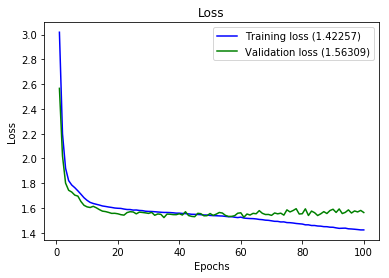

In [31]:
plot_history(history)

In [34]:
#Je regarde à quel point il est bon
#Je load les weights du modèle pas la peine de réentraîner hehe
start_new_session()
model = create_model(data.metadata, clusters)
#c'est là que je load les weights
model.load_weights('cache\TrainedOn10_2_5-100-1.5631.hdf5')


In [36]:
#Les prédictions sur l'ensemble de test de la compet (tout petit)
test_predictions = model.predict(process_features(data.test))

In [37]:
os.chdir('code')
from utils import np_haversine
os.chdir('..')
np_haversine(test_predictions, data.test_labels).mean()

1.4601464225973106

En s'entraînant que sur le dixième des données, on obtient une loss de 1.46 (km) sur le truc de test. C'est mieux que sur le blog... Soit j'ai mal copié un truc qui fait que ça marche mieux hahah, soit keras 2.x et meilleur que 1.x